# Cell 1: Install and Import Required Libraries


In [1]:
# Install necessary libraries if not already installed
!pip install spacy xgboost

# Import libraries
import os
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load Spacy model
nlp = spacy.load("en_core_web_sm")


# Cell 2: Load and Display Dataset

In [3]:
# Load the CSV file
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')

# Display first 5 rows
df.head()


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Cell 3: Advanced Text Preprocessing

In [5]:
def clean_text(text):
    doc = nlp(text.lower())  # Convert text to lowercase and process with spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Lemmatization, remove stopwords
    return ' '.join(tokens)

# Apply the function to the dataset
df['clean_resume'] = df['Resume_str'].astype(str).apply(clean_text)

# Display processed text
df[['Resume_str', 'clean_resume']].head()


,Resume_str,clean_resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,hr administrator marketing associate hr admini...
1,"HR SPECIALIST, US HR OPERATIONS ...",hr specialist hr operation summary versatile m...
2,HR DIRECTOR Summary Over 2...,hr director summary year experience recruiting...
3,HR SPECIALIST Summary Dedica...,hr specialist summary dedicated drive dynamic ...
4,HR MANAGER Skill Highlights ...,hr manager skill highlight hr skill hr departm...


# Cell 4: Convert Categories to Numeric Labels

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode categories
encoder = LabelEncoder()
df['Category_label'] = encoder.fit_transform(df['Category'])

# Show mapping of labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Category to Label Mapping:", label_mapping)


Category to Label Mapping: {'ACCOUNTANT': 0, 'ADVOCATE': 1, 'AGRICULTURE': 2, 'APPAREL': 3, 'ARTS': 4, 'AUTOMOBILE': 5, 'AVIATION': 6, 'BANKING': 7, 'BPO': 8, 'BUSINESS-DEVELOPMENT': 9, 'CHEF': 10, 'CONSTRUCTION': 11, 'CONSULTANT': 12, 'DESIGNER': 13, 'DIGITAL-MEDIA': 14, 'ENGINEERING': 15, 'FINANCE': 16, 'FITNESS': 17, 'HEALTHCARE': 18, 'HR': 19, 'INFORMATION-TECHNOLOGY': 20, 'PUBLIC-RELATIONS': 21, 'SALES': 22, 'TEACHER': 23}


# Cell 5: Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_resume'], df['Category_label'], test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 1987, Testing samples: 497


# Cell 6: TF-IDF Vectorization

In [11]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF Vectorization Complete. Shape:", X_train_tfidf.shape)


TF-IDF Vectorization Complete. Shape: (1987, 5000)


# Cell 7: Define and Train Ensemble Model

In [12]:
# Define base models
model_lr = LogisticRegression()
model_rf = RandomForestClassifier(n_estimators=200, random_state=42)
model_nb = MultinomialNB()
model_svm = SVC(kernel='linear', probability=True)
model_xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)

# Create Ensemble (Voting Classifier)
ensemble = VotingClassifier(estimators=[
    ('LR', model_lr),
    ('RF', model_rf),
    ('NB', model_nb),
    ('SVM', model_svm),
    ('XGB', model_xgb)
], voting='soft')

# Train Ensemble Model
ensemble.fit(X_train_tfidf, y_train)

print("Ensemble Model Training Complete!")


Ensemble Model Training Complete!


# Cell 8: Model Evaluation

In [16]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred = ensemble.predict(X_test_tfidf)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Ensemble Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))


Ensemble Model Accuracy: 0.7223
Precision: 0.7268
Recall: 0.7223
F1 Score: 0.7118
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.79      0.77      0.78        30
           2       0.75      0.38      0.50         8
           3       0.71      0.60      0.65        20
           4       0.27      0.17      0.21        18
           5       0.00      0.00      0.00         6
           6       0.90      0.90      0.90        21
           7       0.76      0.70      0.73        23
           8       0.00      0.00      0.00         2
           9       0.93      0.52      0.67        27
          10       0.95      0.79      0.86        24
          11       0.84      0.91      0.87        34
          12       0.57      0.40      0.47        20
          13       0.81      0.89      0.85        19
          14       0.87      0.80      0.83        25
          15       0.65      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

# Cell 9: Confusion Matrix Visualization

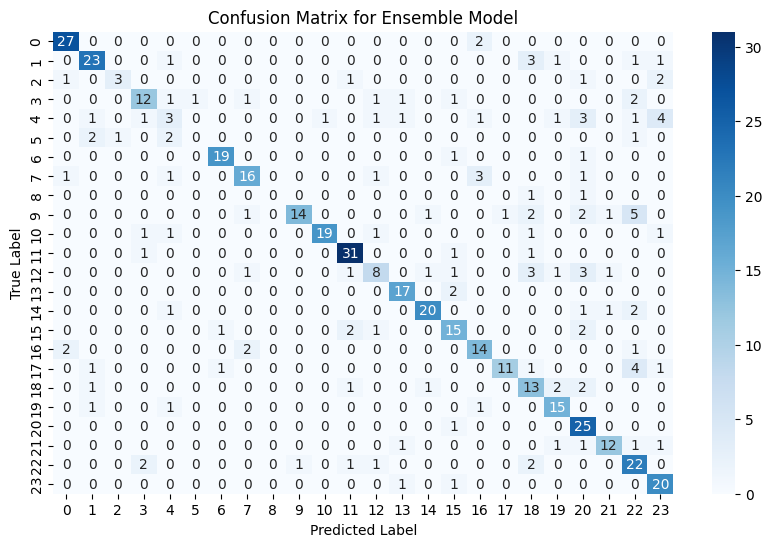

In [17]:
# Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Ensemble Model")
plt.show()
